<a href="https://colab.research.google.com/github/xieruishen/MachineLearningNotebooks/blob/master/MLP_Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchviz
!pip install pycoco

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=e952246ed09433037e7137fc24f94b1390f493fe5a5896bbf1c3934c3fe958aa
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 706kB 5.1MB/s 
     |████████████████████████████████| 409kB 36.2MB/s 
  Created wheel for pycoco: filename=pycoco-0.7.2-cp36-none-any.whl size=9791 sha256=25a9daff90d8ba2dd66c757c406b1818d9d48be33737864de1166da5d5b5683b
  Stored in directory: /root/.cache/pip/wheels/d5/9f/9c/6f40b261f0abad9f29cfe967547d036e4bcfa6a225e442a678
  Created wheel for ll-xist: filename=ll_xist-5.53-cp36-cp36m-linux_x86_64.whl size=606482 sha256=74cd3772ba555ac936553ea0d76c6358043c3d0c480d7d47166791b9c2bb8d80
  Stored in directory: /root/.cache/pip/wheels/66/23/56/de77a624279e15511955acd3a02fa8deece242ffbffc66d781
Successfully built 

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import gdown
import time

import matplotlib.pyplot as plt
import numpy as np # we always love numpy

In [3]:
from zipfile import ZipFile
import gdown
#https://drive.google.com/open?id=1Fn29oJ4kT3dp9Hd3NnAicblRRPKg_5XN
#'https://drive.google.com/uc?authuser=0&id=1M3doqupItS419I6z-D3rCHUaPo93HbUE&export=download'
data_zip=gdown.download('https://drive.google.com/uc?authuser=0&id=1Fn29oJ4kT3dp9Hd3NnAicblRRPKg_5XN&export=download',  'asl-alphabet.zip', quiet=False)
# Create a ZipFile Object and load sample.zip in it

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1Fn29oJ4kT3dp9Hd3NnAicblRRPKg_5XN&export=download
To: /content/asl-alphabet.zip
3.01GB [00:13, 229MB/s]


In [0]:
!unzip -qq -o asl-alphabet.zip
!cd asl-alphabet/asl_alphabet_train/asl_alphabet_train && rm -r del

In [5]:
!cd asl-alphabet/asl_alphabet_train/asl_alphabet_train && ls

A  C  E  G  I  K  M  nothing  P  R  space  U  W  Y
B  D  F  H  J  L  N  O	      Q  S  T	   V  X  Z


In [0]:
class_len = 28
class_mappings = {'A': 0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'nothing':27}
class_upgrade={0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z',26:'space',27:'nothing'}
# Define a function to parse a sample label into a form that we want (aka a tensor)
def get_classes(target):
  class_tensor = torch.zeros((class_len),dtype=torch.long)
  class_tensor[target] = 1
  return class_tensor

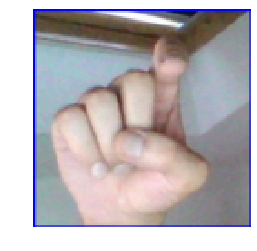

torch.Size([3, 120, 120])


In [7]:
from torchvision.datasets import ImageFolder

def show_image(img_tensor):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.show()

cal_tech = ImageFolder(root='asl-alphabet/asl_alphabet_train/asl_alphabet_train/', transform=transforms.Compose([transforms.CenterCrop((200,200)),
                                                    transforms.Resize((120,120)),
                                                    transforms.ToTensor()]))

im, target = cal_tech[70110]
show_image(im)
print(im.shape)

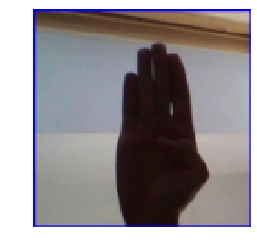

In [8]:
cal_tech_t = ImageFolder(root='asl-alphabet/asl_alphabet_test/asl_alphabet_test/', transform=transforms.Compose([transforms.CenterCrop((200,200)),
                                                    transforms.Resize((120,120)),
                                                    transforms.ToTensor()]))

im_t, target_t = cal_tech_t[1]
show_image(im_t)

In [0]:
train_set=cal_tech
test_set=cal_tech_t
image_dims= 3,120,120
n_training_samples=84000
n_test_samples=20
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [0]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.activation_func = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0)
        self.fc1_size = 256
        self.fc2_size = class_len
        # Convolutional Layers
        self.conv1 = nn.Conv2d(image_dims[0], 32, kernel_size=3,
                  stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,
          stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,
          stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,
          stride=1, padding=1)
        # tensor height width and depth
        self.maxpool_output_size = int(256 * (image_dims[1]/40) * (image_dims[2] / 40))
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.maxpool_output_size, self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size, self.fc2_size)
        
    def forward(self, x):
        # Convolutional Layers
        x = self.activation_func(self.pool2(self.conv1(x)))
        x = self.activation_func(self.pool2(self.conv2(x)))
        x = self.activation_func(self.pool2(self.conv3(x)))
        x = self.activation_func(self.pool5(self.conv4(x)))
        # Fully Connected Layers
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    def get_loss(self, learning_rate):
      # Loss function, we'll use BCE or Binary CrossEntropy that does not assume one class fer example
      # https://pytorch.org/docs/stable/nn.html
      loss = nn.CrossEntropyLoss()
      #loss = nn.BCEWithLogitsLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

## Model Architecture
First let's create our model. Let's also check out a graphical representation of our model (using a library we downloaded earlier) to validate the model looks like we think it should.  This is definitely not the prettiest visualization, and there are lots of things included in here that are related to doing the backward pass (to compute the gradients).  Of particular relevance are the blue nodes, which tell you about the various model parameters and layers.

**Running the below cell will override your model if have already trained one**

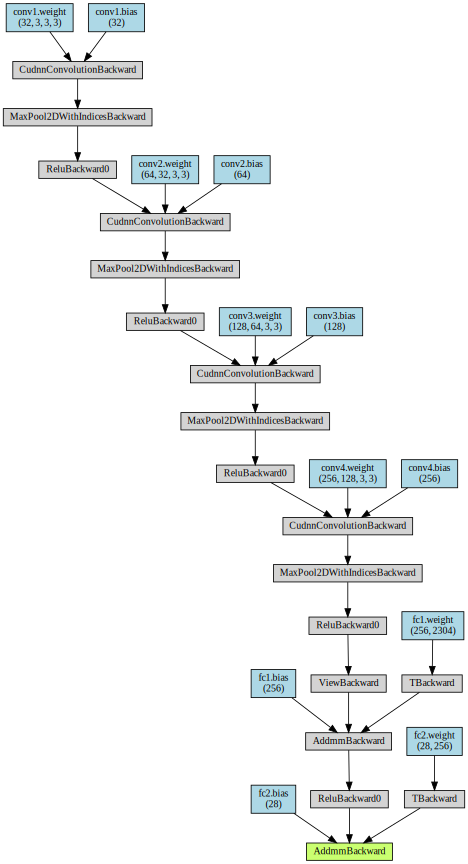

In [13]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))
# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net_example = myCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net_example.to(device)

visualize_network(net_example)

If not use pretrain model

In [0]:
# Define training and testing parameters
device='cuda'
net=myCNN()
net.to(device)
batch_size = 32
test_batch_size = 10
learning_rate = 3e-3
n_epochs = 8

In [15]:
# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                        sampler=train_sampler, num_workers=2)
print(train_set.classes)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=test_batch_size, sampler=test_sampler, num_workers=2)
loss, optimizer = net.get_loss(learning_rate)
print("loss:", loss)
print(test_set.classes)
print(test_loader.dataset)
# Define some parameters to keep track of metrics
print_every = 20
test_every = 200
idx = 0
train_hist_x = []
train_loss_hist = []
test_hist_x = []
test_loss_hist = []

def convert_targets_to_hot_encoding_for_test(targets):
  targets_tensor = torch.zeros(test_batch_size,28,device=torch.device("cuda"))
  for index in range(test_batch_size):
    targets_tensor[index][targets[index]] = 1
  return targets_tensor

# Get the brute accuracy of our model
# This doesn't really do a good job of characterizing the performance as it is the
# raw accuracy (which includes predicting 0 versus 1 for each class)
def get_acc(output,targets):
    # Get the guess of each class
    output = torch.round(torch.sigmoid(output))
    # Compare guesses
    targets = convert_targets_to_hot_encoding_for_test(targets)
    diff = targets - output
    avg = torch.mean(torch.abs(diff))
    return 1 - avg


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
loss: CrossEntropyLoss()
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
Dataset ImageFolder
    Number of datapoints: 28
    Root location: asl-alphabet/asl_alphabet_test/asl_alphabet_test/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(200, 200))
               Resize(size=(120, 120), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [16]:
def test_loss(run_idx):
    # do a pass on the test set
    total_test_loss = 0
    total_acc_loss = 0
    idx = 0
    for inputs, labels in test_loader:
        # Wrap tensors in Variables
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        test_outputs = net(inputs)
        test_loss_size = loss(test_outputs, labels)
        total_test_loss += test_loss_size.data.item()
        total_acc_loss += get_acc(test_outputs, labels)
        if idx >= 100:
          break
        idx += 1
    test_loss_hist.append(total_test_loss / (idx+1))
    test_hist_x.append(run_idx)
    print("Validation loss = {:.4f}".format(
        total_test_loss / (idx+1)))
    print("Validation Accuracy = {:.4f}".format(
        total_acc_loss / (idx+1)))


training_start_time = time.time()
# Loop for n_epochs
for epoch in range(n_epochs):
  running_loss = 0.0
  start_time = time.time()

  for i, data in enumerate(train_loader, 0):

    # Get inputs in right form
    inputs, labels = data
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
    
    # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(inputs)
    
    # Compute the loss and find the loss with respect to each parameter of the model
    loss_size = loss(outputs, labels)
    loss_size.backward()
    
    # Change each parameter with respect to the recently computed loss.
    optimizer.step()

    # Update statistics
    running_loss += loss_size.data.item()
    
    # Print every 20th batch of an epoch
    if (i % print_every) == print_every-1:
        print("Epoch {}, Iteration {}\t train_loss: {:.4f} took: {:.4f}s".format(
            epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
        # Reset running loss and time
        train_loss_hist.append(running_loss / print_every)
        train_hist_x.append(idx)
        running_loss = 0.0
        start_time = time.time()
    # Check test set every nth batch
    if (i % test_every) == test_every -1:
        print("index before test_loss:", idx)
        test_loss(idx)
        
        idx += 1
print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

Epoch 1, Iteration 20	 train_loss: 3.3341 took: 1.5189s
Epoch 1, Iteration 40	 train_loss: 3.3344 took: 1.1793s
Epoch 1, Iteration 60	 train_loss: 3.3315 took: 1.2285s
Epoch 1, Iteration 80	 train_loss: 3.3337 took: 1.2825s
Epoch 1, Iteration 100	 train_loss: 3.3313 took: 1.2214s
Epoch 1, Iteration 120	 train_loss: 3.3318 took: 1.1823s
Epoch 1, Iteration 140	 train_loss: 3.3352 took: 1.2264s
Epoch 1, Iteration 160	 train_loss: 3.3328 took: 1.2133s
Epoch 1, Iteration 180	 train_loss: 3.3346 took: 1.3112s
Epoch 1, Iteration 200	 train_loss: 3.3316 took: 1.1969s
index before test_loss: 0
Validation loss = 2.2247
Validation Accuracy = 0.3976
Epoch 1, Iteration 220	 train_loss: 3.3319 took: 1.4007s
Epoch 1, Iteration 240	 train_loss: 3.3336 took: 1.2373s
Epoch 1, Iteration 260	 train_loss: 3.3329 took: 1.2711s
Epoch 1, Iteration 280	 train_loss: 3.3342 took: 1.1892s
Epoch 1, Iteration 300	 train_loss: 3.3330 took: 1.2243s
Epoch 1, Iteration 320	 train_loss: 3.3322 took: 1.2379s
Epoch 1, Ite

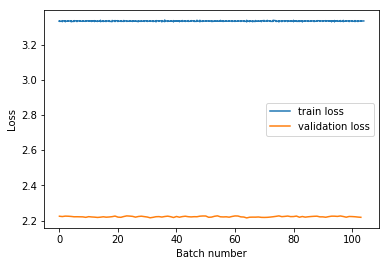

In [17]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

In [20]:
print(train_hist_x)
print(train_loss_hist)
print(test_hist_x)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27,

In [0]:
# loading and saving via this link:
# https://medium.com/udacity-pytorch-challengers/saving-loading-your-model-in-pytorch-741b80daf3c
from google.colab import drive
drive.mount('/content/gdrive')
checkpoint = {'model': myCNN(),
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict()
        }
f = open('/content/gdrive/My Drive/asl_pretrained.pth', 'wb')
torch.save(checkpoint, f)
f.close()
from google.colab import files
files.download('/content/gdrive/My Drive/asl_pretrained.pth')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type myCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Downloading...
From: https://drive.google.com/uc?authuser=0&id=1SDCCXQ67aM9QnMT5_419_x5Ek6_ueQKT&export=download
To: /content/asl_pretrained(5).pth
15.8MB [00:00, 82.8MB/s]


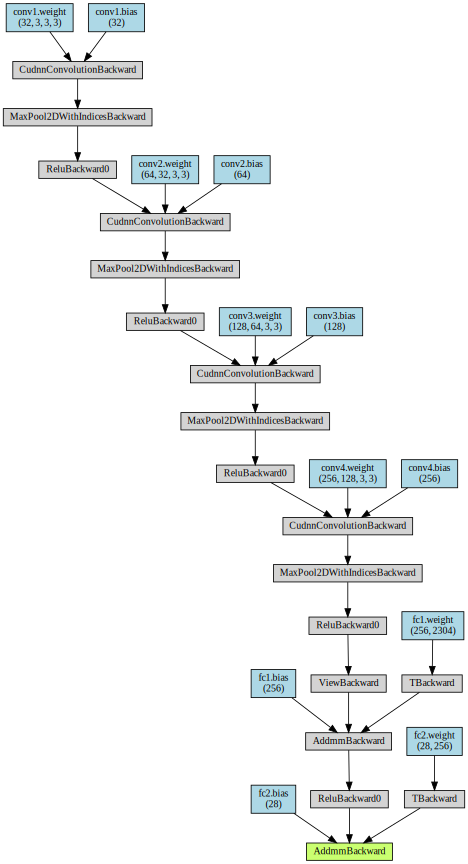

In [0]:
use_pretrained_model = True

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = myCNN()

if use_pretrained_model:
    gdown.download('https://drive.google.com/uc?authuser=0&id=1SDCCXQ67aM9QnMT5_419_x5Ek6_ueQKT&export=download',
                   'asl_pretrained(5).pth',
                   quiet=False)
    #https://drive.google.com/open?id=1SDCCXQ67aM9QnMT5_419_x5Ek6_ueQKT
    #https://drive.google.com/open?id=1w4RW2U8QMK3kw8A8oA-DEhglInU4uy0a
    check_point = torch.load('asl_pretrained(5).pth')
    
    net.load_state_dict(check_point['state_dict'])

# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

# Visualize the architecture of the model
# We need to give the net a fake input for this library to visualize the architecture
fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
outputs = net(fake_input)
# Plot the DAG (Directed Acyclic Graph) of the model
make_dot(outputs, dict(net.named_parameters()))

In [0]:
#### sadness ####

from torch.utils.data import Dataset
from PIL import Image
from torchvision.datasets import VisionDataset
import os
from glob import glob
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def show_image(img_tensor):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.show()

# Datasets must always subclass either Dataset (either directly or indirectly)
# Here, we use subclass the VisionDataset class, which is more standard for
# computer vision datasets.
class Caltech256(VisionDataset):
    def __init__(self, transform=None, target_transform=None):
        # make sure to call the super class init method
        super(Caltech256, self).__init__('.',
                                         transform=transform,
                                         target_transform=target_transform)
        
        # we'll keep track of the categories here
        self.categories = []
        # the index will help us find the jpegs to load
        self.index = []
        # the y list will be used to determine the object category
        self.y = []
        # all of the data is extracted to the 256_ObjectCategories directory
        # we search for all files that match ???.* (three characters followed
        # by a . followed by any string).  This pattern matches all of the
        # object directories we are interested in parsing.

        class_mappings = {'A': 0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'del':27,'nothing':28}

        for c in sorted(glob(os.path.join(self.root, "asl_alphabet_train","asl_alphabet_train","*"))):
            #print(c)
            # get just the object category directory
            _, category_dir = os.path.split(c)
            # convert from 1 index to 0 index class
            class_idx = class_mappings[category_dir]
            #print(class_idx)
            # there is an extra background class that we don't care about
            # count the jpegs in the appropriate directory
            img_files = glob(os.path.join(self.root, "asl_alphabet_train","asl_alphabet_train", category_dir, '*.jpg'))
            n = len(img_files)
            # populate the categories
            #self.categories.append(category_dir)
            self.index.extend(img_files)
            self.y.extend(n * [class_idx])
            #print(self.index)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # load the image using PIL
        # a gotcha is when some of the images are black and white, we can use
        # the convert('RGB') command to make sure everything is a three channel
        # RGB image.
        img = Image.open(self.index[index]).convert('RGB')
        # the target has been cached in y
        target = self.y[index]

        # apply transformations if they exist (this is useful for images)
        if self.transform is not None:
            img = self.transform(img)

        # apply transformations if they exist (this is useful for images)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        # you need to say how much data you have
        return len(self.index)


# center crop 200, 200 pixel patch and then resize to 100 by 100 for
# computational efficiency
cal_tech = Caltech256(transform=transforms.Compose([transforms.CenterCrop((200,200)),
                                                    transforms.Resize((100,100)),
                                                    transforms.ToTensor()]))

im, target = cal_tech[2000]
show_image(im)
#print(im.shape)

In [0]:
# import os
# letters={'A': 0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'nothing':27}
# for key in letters.keys():
#   # define the name of the directory to be created
#   path = "/content/asl_alphabet_test/asl_alphabet_test/"+key

#   try:
#       os.mkdir(path)
#   except OSError:
#       print ("Creation of the directory %s failed" % path)
#   else:
#       print ("Successfully created the directory %s " % path)
# !cd asl_alphabet_test/asl_alphabet_test && ls
# # 

In [0]:
# import shutil
# #shutil.move("/content/asl_alphabet_test/asl_alphabet_test/A_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/A/A_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/B_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/B/B_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/C_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/C/C_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/D_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/D/D_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/E_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/E/E_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/F_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/F/F_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/G_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/G/G_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/H_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/H/H_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/I_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/I/I_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/J_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/J/J_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/K_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/K/K_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/L_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/L/L_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/M_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/M/M_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/N_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/N/N_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/O_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/O/O_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/P_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/P/P_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/Q_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/Q/Q_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/R_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/R/R_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/S_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/S/S_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/T_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/T/T_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/U_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/U/U_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/V_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/V/V_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/W_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/W/W_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/X_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/X/X_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/Y_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/Y/Y_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/Z_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/Z/Z_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/nothing/nothing_test.jpg")
# shutil.move("/content/asl_alphabet_test/asl_alphabet_test/space_test.jpg","/content/asl_alphabet_test/asl_alphabet_test/space/space_test.jpg")